In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, cohen_kappa_score
from IPython.display import HTML, display
import itertools
import seaborn as sns

In [2]:
def normalize(x):
    return (x - x.mean()) / x.std()

def compute_acc(ground_truth, x):
    vals = x.iloc[:, 0].values
    return accuracy_score(ground_truth, vals <= vals.mean())

def get_metrics_df(_df, background_df):
    _metrics_df = pd.DataFrame()
    for col_idx, col in enumerate(_df.columns):
        if _df.loc[:, col].notna().all():
            _metrics_df.loc[:, f"player {col_idx}"] = _df.loc[:, col].reset_index(drop=True)
    _metrics_df.loc[:, "avg_pred"] = _df.mean(axis=1).reset_index(drop=True)
    _metrics_df.loc[:, "bool_pred"] = _metrics_df["avg_pred"] <= 3
    _metrics_df.loc[:, "bool_scaled_pred"] = _metrics_df["avg_pred"] <= _metrics_df["avg_pred"].mean()
    _metrics_df.loc[:, "high_pred"] = _df.max(axis=1).reset_index(drop=True)
    _metrics_df.loc[:, "bool_high_pred"] = _metrics_df.high_pred <= 3
    _metrics_df.loc[:, "low_pred"] = _df.min(axis=1).reset_index(drop=True)
    _metrics_df.loc[:, "bool_low_pred"] = _metrics_df.low_pred <= 3
    _metrics_df.loc[:, "bool_is_human"] = background_df.is_human.reset_index(drop=True)
    _metrics_df.loc[:, "is_human"] = _metrics_df["bool_is_human"].apply(int)
    _metrics_df.loc[:, "missed"] = _metrics_df["bool_scaled_pred"] != _metrics_df["is_human"]
    _metrics_df.loc[:, "catched"] = _metrics_df["bool_scaled_pred"] == _metrics_df["is_human"]
    return _metrics_df

In [3]:
background_dfs = [pd.read_csv(f"./llama/human_eval/data/llama_7b_fine_tuned_shorter/human_eval_df1_{i}.csv", index_col=0) for i in range(1, 6)]
no_control_questions = []
new_bkg_dfs = []
for idx, background_df in enumerate(background_dfs):
    background_df.index = [f"Domanda {idx * 20 + i}" for i in range(1, 21)]
    no_control_questions.append([f"Domanda {idx * 20 + i}" for i in range(1, 21) if i != 7])
    background_df = background_df.loc[no_control_questions[idx], :]
    new_bkg_dfs.append(background_df)
background_df = pd.concat(new_bkg_dfs, axis=0)
_dfs = [pd.read_csv(f"./llama/human_eval/svolgimenti/Svolgimento_df1_{i}.csv") for i in range(5)]
_new_dfs = []
all_metrics_df = []
for idx, _df in enumerate(_dfs):
    _df = _df.loc[_df.Stato == "Completato"]
    # print(_df.filter(regex="Domanda*"))
    _df = (
        _df.filter(regex="Domanda*").applymap(
            lambda x: float(
                str(x)
                .replace(" (sicuramente scritto da una persona)", "")
                .replace(" (sicuramente scritto da una macchina)", "")
                .replace("Risposta ", "")
                )
            )
    )
    _df = _df.loc[_df.loc[:, "Domanda 7"] > 3, :]
    _df = _df.rename({f"Domanda {i}": f"Domanda {idx * 20 + i}" for i in range(1, 21)}, axis=1)
    _df = _df.loc[:, no_control_questions[idx]]
    _df = _df.T
    _new_dfs.append(_df)
    _metrics_df = get_metrics_df(_df, new_bkg_dfs[idx])
    all_metrics_df.append(_metrics_df)
_df = pd.concat(_new_dfs, axis=0)
_df = pd.DataFrame([i[~np.isnan(i)][:5] for i in _df.values])

metrics_df = get_metrics_df(_df, background_df)

In [4]:
(
    accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_scaled_pred"]),
    accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_pred"]),
    accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_high_pred"]),
    accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_low_pred"]),
)

(0.6842105263157895,
 0.6631578947368421,
 0.6210526315789474,
 0.5473684210526316)

In [5]:
all_cohens = []
for idx, metrics_df in enumerate(all_metrics_df):
    print(f"Questionair {idx + 1}")
    quest_x = []
    print(
        np.round(accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_scaled_pred"]),3) * 100,
        np.round(accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_pred"]),3) * 100,
        np.round(accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_high_pred"]),3) * 100,
        np.round(accuracy_score(metrics_df["bool_is_human"], metrics_df["bool_low_pred"]),3) * 100,
    )
    for i in range(5):
        acc = accuracy_score(
            metrics_df.loc[:, f"bool_is_human"],
            metrics_df.loc[:, f"player {i}"] < 3.0
        )
        print("\t", acc)
        quest_x.append(acc)
    all_data = np.zeros((5, 5))
    for i,j in itertools.combinations(range(5), r=2):
        all_data[i,j] = cohen_kappa_score(
            metrics_df.loc[:, f"player {i}"] < 3.0,
            metrics_df.loc[:, f"player {j}"] < 3.0
        )
    all_cohens.append(all_data)
    acc = accuracy_score(
        metrics_df.loc[:, f"bool_is_human"],
        metrics_df.loc[:, "bool_scaled_pred"]
    )
    print(f"\t Micro Avg acc {acc}")
    print(f"\t Macro Avg acc {np.mean(quest_x)}")

Questionair 1
78.9 68.4 63.2 52.6
	 0.5789473684210527
	 0.6842105263157895
	 0.7894736842105263
	 0.7368421052631579
	 0.3684210526315789
	 Micro Avg acc 0.7894736842105263
	 Macro Avg acc 0.631578947368421
Questionair 2
63.2 47.4 63.2 52.6
	 0.5263157894736842
	 0.3684210526315789
	 0.631578947368421
	 0.47368421052631576
	 0.5789473684210527
	 Micro Avg acc 0.631578947368421
	 Macro Avg acc 0.5157894736842105
Questionair 3
68.4 73.7 36.8 57.9
	 0.7368421052631579
	 0.47368421052631576
	 0.5789473684210527
	 0.6842105263157895
	 0.47368421052631576
	 Micro Avg acc 0.6842105263157895
	 Macro Avg acc 0.5894736842105264
Questionair 4
78.9 73.7 78.9 52.6
	 0.7368421052631579
	 0.7368421052631579
	 0.6842105263157895
	 0.8421052631578947
	 0.7894736842105263
	 Micro Avg acc 0.7894736842105263
	 Macro Avg acc 0.7578947368421053
Questionair 5
57.9 73.7 63.2 57.9
	 0.5789473684210527
	 0.6842105263157895
	 0.5789473684210527
	 0.8421052631578947
	 0.5263157894736842
	 Micro Avg acc 0.5789473

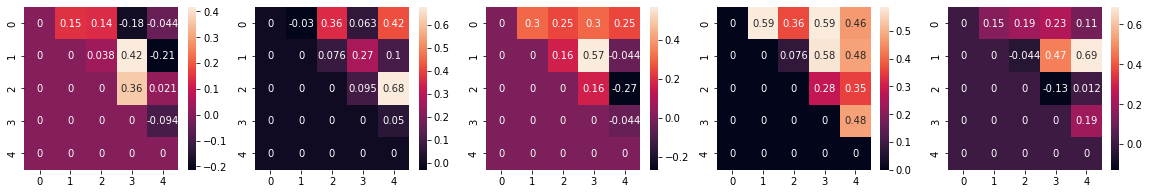

In [12]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
for i in range(5):
    sns.heatmap(
        all_cohens[i],
        annot=True,
        ax=ax[i]
    )

In [208]:
for _, i in background_dfs[1].iterrows():
    print(len(i["Testo domanda"].split(" ")))
    display(HTML(i["Testo domanda"]))
    for idx in range(5):
        idx += 1
        display(HTML(str(i[f"Testo risposta {idx}"])))

105


105


105


105


105


105


107


105


105


105


105


105


105


105


105


105


105


105


105


105
